In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.ion()

import seaborn as sns
sns.set(font_scale=1.5, style='white')
import numpy as np

# Load data

## Google Analytics

In [2]:
ga = pd.read_csv('../data/daily_ga.csv', index_col=0)

## Billing data

In [3]:
url_data = "https://raw.githubusercontent.com/jupyterhub/binder-data/master/billing/data/proc/data.json"
data = pd.read_json(url_data, orient='split')
data['date'] = pd.to_datetime(data['date'])

# Set end date

We'll freeze the end date to keep the plots static

In [4]:
end_date = '2018-06-10'
data = data.query('date < @end_date')

## Categories of cost

In [5]:
categories = data.groupby(['date', 'category', 'line_item']).sum()['cost'].\
    unstack(['category', 'line_item'])

sort_categories = categories.sum(0)
sort_categories = sort_categories.sort_values(ascending=False).index

categories = categories[sort_categories]

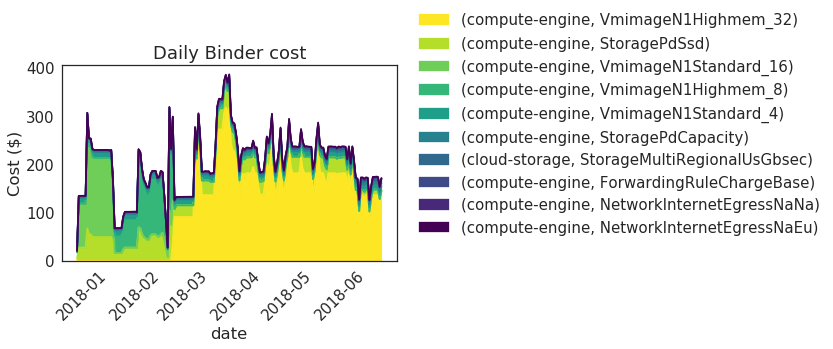

In [6]:
ax = categories.iloc[:, :10].plot.area(cmap=plt.cm.viridis_r)
ax.legend(loc=(1.05, .1), framealpha=0)
ax.set(title="Daily Binder cost", ylabel="Cost ($)")
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');


# Plotting

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


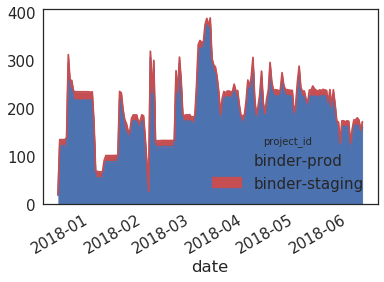

In [7]:
# Costs
costs = data.groupby(['project_id', 'date']).sum()['cost'].unstack('project_id')
costs.plot.area(stacked=True, colors=["C0", "C2"])

In [8]:
ga_daily = ga.groupby('date').sum()['unique_pageviews'].to_frame()
costs_subset = costs.drop('binder-staging', axis=1).rename(columns={'binder-prod': 'daily_cost'})
total_costs = pd.merge(ga_daily, costs_subset, left_index=True, right_index=True)
total_costs['cost_per_user'] = total_costs['daily_cost'] / total_costs['unique_pageviews']

In [9]:
def dollars(x, pos):
    'The two args are the value and tick position'
    return '${:.2f}'.format(x)

formatter = FuncFormatter(dollars)

In [10]:
# Update columns with a category level
kinds = []
for col in categories.columns:
    if "Vmimage" in col[1]:
        kind = 'machine'
    elif "Storage" in col[1]:
        kind = "storage"
    elif "Forwarding" in col[1] or "Network" in col[1]:
        kind = "network"
    else:
        kind = "miscellaneous"
    kinds.append(kind)

categories_plot = categories.copy()
categories_plot.columns = pd.Index(kinds, name='kind')
categories_plot = categories_plot.stack().reset_index('kind').groupby(['date', 'kind']).sum()[0].unstack('kind')
sorted_cols = categories_plot.mean().sort_values(ascending=False).index
categories_plot = categories_plot[sorted_cols]

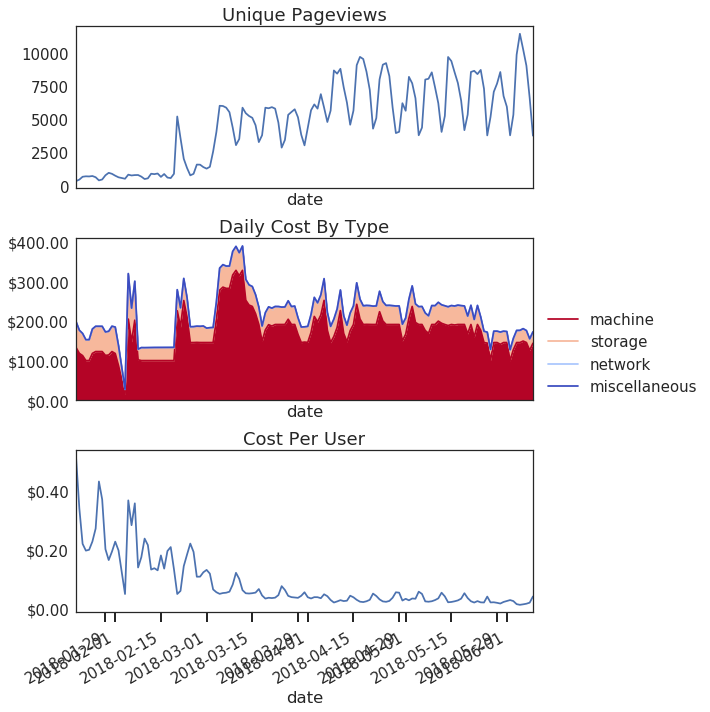

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
for ax, key in zip(axs[[0, 2]], ['unique_pageviews', 'cost_per_user']):
    total_costs[key].plot(ax=ax)
    ax.set(title=' '.join([ii.capitalize() for ii in key.split('_')]))

labels = categories_plot.columns.values
categories_plot.plot.area(cmap=plt.cm.coolwarm_r, ax=axs[1])
axs[1].legend(labels, loc=(1.02, 0))
axs[1].set(title="Daily Cost By Type")
for ax in axs[[1, 2]]:
    ax.yaxis.set_major_formatter(formatter)
axs[2].set(xlim=[total_costs.index.min(), total_costs.index.max()])
ax.tick_params('x', length=10, width=2)
plt.tight_layout()

path_fig = '../../scipy_proceedings/papers/project_jupyter/images/cost_breakdown.png'
# fig.savefig(path_fig, transparent=True, bbox_inches='tight')

In [12]:
print("Average costs, last 10 days:")
for col, vals in total_costs.tail(20).items():
    print("{}: {:.3f}".format(col, vals.mean()))

Average costs, last 10 days:
unique_pageviews: 7338.250
daily_cost: 165.575
cost_per_user: 0.024
